# Réalisez un détecteur de slides grâce à de l'analyse d'image

## Fonctions outils

(code à exécuter sans y prêter attention)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# dimensions des images
height = 72
width = 128

# Fonctions d'affichage des images
def display_image(video, image_position):
    try:
        img = video[video.position == image_position]
        url = img.index.values[0]
        img = img.values[0]
    except IndexError:
        raise Exception("La position demandée n'est pas disponible")
    img = img[1:] # On supprime la première colonne qui correspond à la position de l'image (en secondes)
    
    display_with_pylab(img, url)
    
def display_compressed_image(pca, std_scaler, X_projected, image_position, list_of_positions):
    try:
        i = np.where(list_of_positions == image_position)[0][0]
    except IndexError:
        raise Exception("La position demandée n'est pas disponible")
        
    compressed_img = X_projected[i]
    img = decompress_image(pca, std_scaler, compressed_img)
    url = list_of_positions.index[i]
    
    display_with_pylab(img, url)

def display_with_pylab(img, url=None):
    img = img.reshape(height, width, 3) # On remet l'image sous forme d'un numpy array de height*width*3
    img = img * 4 # On remet l'échelle des couleurs de 0 à 256
    img = np.array(img, dtype=np.float64)
    if url:
        print(url)
    fig = pylab.figure()
    pylab.imshow(img.astype(np.uint8))
    plt.show()   
    
def decompress_image(pca, std_scaler, compressed_img):
    img = pca.inverse_transform(compressed_img)
    img = std_scaler.inverse_transform(img)
    return img

## Chargement des données

Nous importons le CSV et stockons la matrice dans un array numpy appelé X. Cette opération peut prendre quelques secondes. Ensuite, nous affichons l'image de la 150e seconde.

https://youtu.be/uV5hmpzmWsU?t=150s


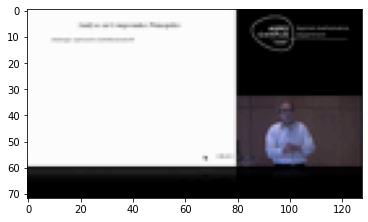

                                      position   0   1   2   3   4   5   6  \
https://youtu.be/uV5hmpzmWsU?t=0s            0   0   0   0   0   0   0   0   
https://youtu.be/uV5hmpzmWsU?t=3s            3   0   0   0   0   0   0   0   
https://youtu.be/uV5hmpzmWsU?t=6s            6   0   0   0   0   0   0   0   
https://youtu.be/uV5hmpzmWsU?t=9s            9   0   0   0   0   0   0   0   
https://youtu.be/uV5hmpzmWsU?t=12s          12   0   0   0   0   0   0   0   
...                                        ...  ..  ..  ..  ..  ..  ..  ..   
https://youtu.be/uV5hmpzmWsU?t=5787s      5787  62  62  62  63  63  63  63   
https://youtu.be/uV5hmpzmWsU?t=5790s      5790  62  62  62  63  63  63  63   
https://youtu.be/uV5hmpzmWsU?t=5793s      5793   9   9   9   8   8   8  16   
https://youtu.be/uV5hmpzmWsU?t=5796s      5796   9   9   9   8   8   8  17   
https://youtu.be/uV5hmpzmWsU?t=5799s      5799   9   9   9   8   8   8  16   

                                       7   8  ...  27638  27639

In [2]:
# Chargement de la vidéo (peut prendre quelques secondes)
try:
    video
except NameError:
    video = pd.read_csv("data/video.csv", index_col= 0)
    
display_image(video,150)
print(video)

X = video.values[:,1:] # On supprime la première colonne qui correspond à la position de l'image (en secondes)

## ACP et réduction de dimensions

Comme il y a beaucoup de colonnes, nous réduisons les données grâce à une ACP après centrage-réduction des données. Nous remplaçons donc toutes nos colonnes par les  n_comp  premières composantes principales, pour avoir un tableau de données avec  n_comp  colonnes.

In [3]:
n_comp = 60

# centrage-réduction
X = X.astype(np.float64) # conversion des nombres entiers en nombres décimaux (float) : necessaire pour le StandardScaler
std_scaler = preprocessing.StandardScaler().fit(X)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [5]:
X_scaled = std_scaler.transform(X)

In [6]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components= n_comp)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [7]:
pca.fit(X_scaled)

PCA(n_components=60)

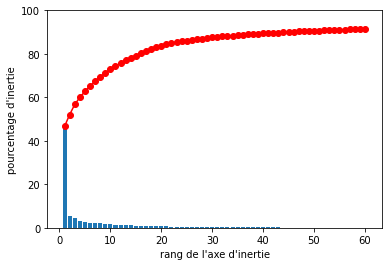

In [8]:
X_projected = pca.transform(X_scaled)

# Affichage des éboulis
eboulis = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(eboulis))+1, eboulis)
plt.plot(np.arange(len(eboulis))+1, eboulis.cumsum(),c="red",marker='o')
plt.ylim(0,100)
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.show()

Remarquez que nous avons ici effectué une compression de vidéo ! Il existe des formats informatiques d'images ou de vidéos compressées (jpeg, mp4, etc.). Certains de ceux-ci se basent sur des méthodes de compressions similaires à l'ACP !

Le calcul des composantes principales peut prendre ici plusieurs secondes, soyez patient. ;)

Après compression de la vidéo, on a forcément perdu en qualité. Affichons l'image de la 150e seconde pour voir cette perte de qualité :

https://youtu.be/uV5hmpzmWsU?t=150s


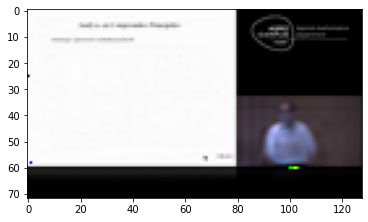

In [9]:
display_compressed_image(pca, std_scaler, X_projected, 150, video["position"])

En affichant les individus projetés sur les premiers plans factoriels, on voit déjà quelques groupes d'images similaires.

Pour les visionner, rendez-vous à cette URL, https://www.youtube.com/watch?v=uV5hmpzmWsU?t=[...]s, en remplaçant le [...] par l'identifiant du point à visualiser. Cet identifiant correspond à la position de l'image dans la vidéo ; il est donné en secondes. Vous pouvez vérifier si deux points proches correspondent à deux images qui se ressemblent.

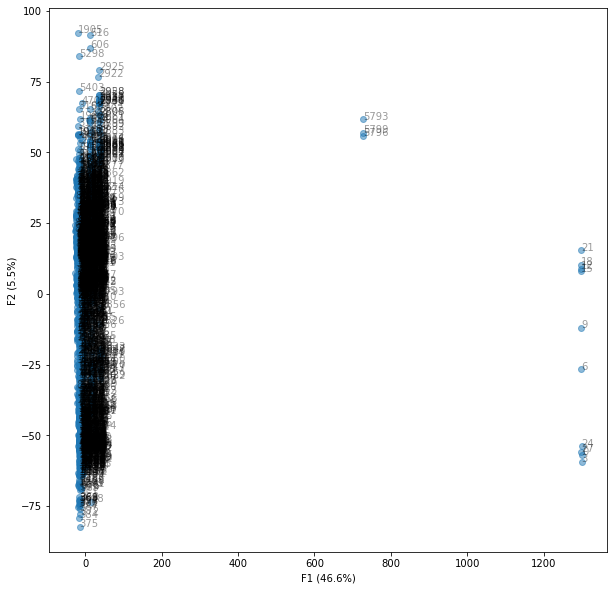

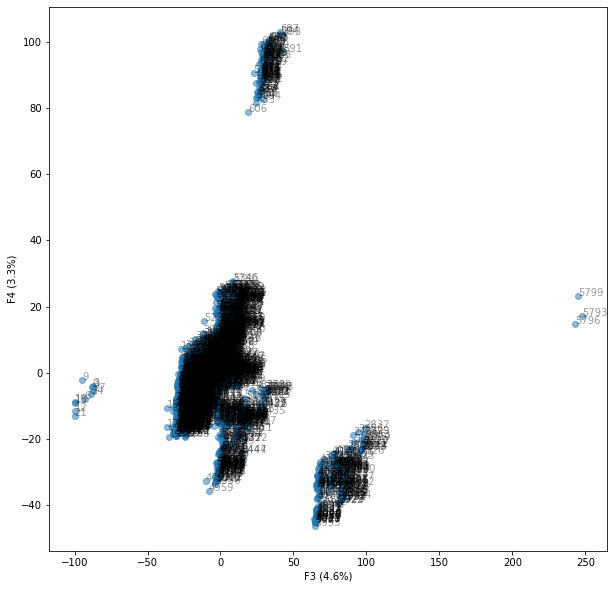

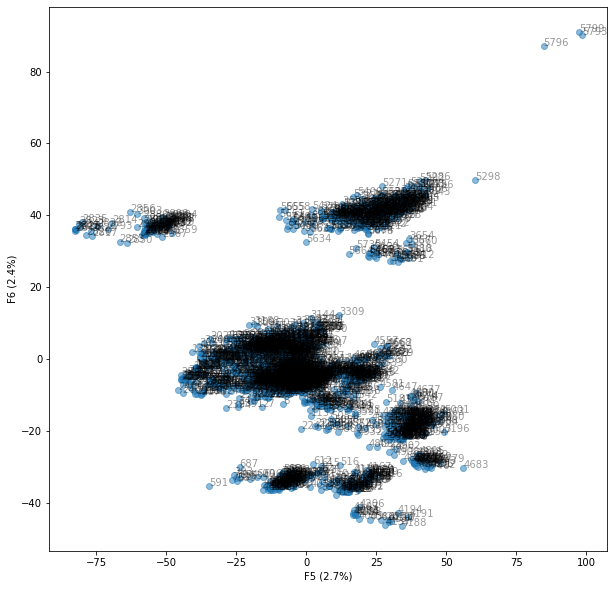

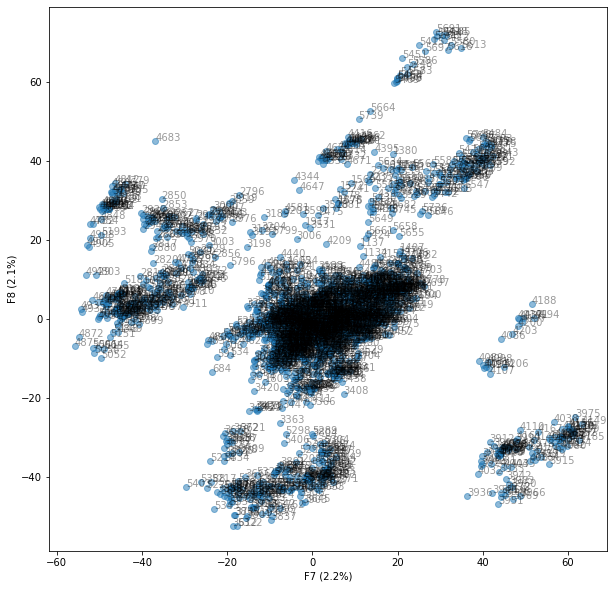

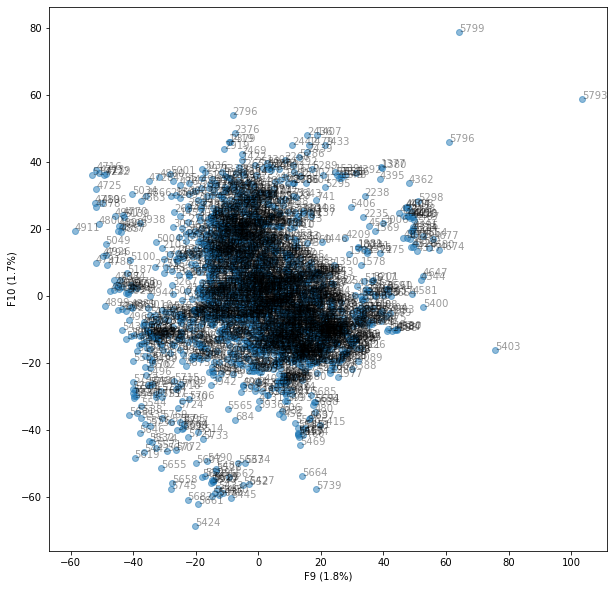

In [10]:
# Affichage des 5 premiers plans factoriels
for d1,d2 in [(0,1),(2,3),(4,5),(6,7),(8,9)]:
    if d2 < n_comp:
        fig = plt.figure(figsize=(10,10))
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha= 0.5)
        
        # On identifie les images par leur position dans la vidéo (en secondes)
        for i in range(len(X_projected)):
            plt.text(X_projected[i, d1], X_projected[i, d2], video["position"][i], alpha= 0.4)

        # nom des axes
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
        
        plt.show()

## Clustering

Nous allons regrouper les images similaires. L'idéal serait d'avoir un groupe par slide différente.

Nous allons donc effectuer une classification hiérarchique et afficher le dendrogramme pour choisir le nombre de classes.

Cependant, il y a trop d'individus (trop d'images) pour effectuer une C.H. rapidement. Nous allons donc d'abord effectuer un clustering avec k-means afin de trouver 300 clusters, en espérant que le professeur n'ait pas plus de 300 slides. Il est fort probable qu'après l'application du k-means, plusieurs clusters correspondent à une même slide : c'est là que la classification hiérarchique sera utile afin de regrouper les clusters correspondant à une même slide.

Remarquons qu'ici, on applique le k-means aux données compressées après ACP, c'est-à-dire à X_projected.

In [11]:
km = KMeans(n_clusters= 300)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [ ]:
km.fit(X_scaled)

In [ ]:
clusters_kmeans = km.labels_
centroids_after_kmeans = km.cluster_centers_
print(centroids_after_kmeans.shape) # 300 centres de n_comp dimensions

Comme les centres de classes sont des points qui ont le même nombre de dimensions (n_comp dimensions) que nos images compressées, on peut afficher ces centres comme des images !

In [ ]:
img = decompress_image(pca, std_scaler, centroids_after_kmeans[3]) # On choisit au hasard le cluster numéro 4
display_with_pylab(img)

Nous allons maintenant effectuer la classification hiérarchique sur les 300 clusters. Le professeur a environ 40 slides différentes. Coupons donc l'arbre en 40 clusters :

In [ ]:
Z = linkage(centroids_after_kmeans, 'ward')

plt.figure(figsize=(15, 7))
plt.ylabel('distance')
dendrogram(Z, no_labels=True)
plt.show()

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [ ]:
final_clusters = fcluster(Z, 12, criterion='maxclust')

In [ ]:
print(final_clusters)

On arrive ainsi à définir quelle image appartient à quel cluster final. Pour chaque cluster, on pioche au hasard une image (on peut prendre par exemple celle qui apparaît en premier), et on l'affiche. En théorie, on ne devrait donc afficher qu'une image par slide. Nous avons atteint notre objectif !

## Résultat

On affiche aussi l'image moyenne du cluster. Elle représente une "image moyenne" composée de plusieurs images. Sur celles-ci, les objets fixes seront nets, et les objets mobiles seront flous. Les slides seront donc nettement visibles !

In [ ]:
for g in range(max(final_clusters)):
    g = g + 1
    print('-'*30,"\nSlide n° ", g)
    km_centers = np.where(final_clusters == g)[0] # renvoie les indexes des centres issus du kmeans qui ont été groupés dans le groupe g après la classification hiérarchique
    img_ind = np.where([c in km_centers for c in clusters_kmeans]) # renvoie les indexes des images similaires, groupées par kmeans puis par classification hiérarchique
    same_slide = video.iloc[img_ind] # renvoie toutes les images montrant une même slide
    first_image = same_slide.sort_values("position").iloc[0]
    
    print("Première image :")
    display_image(video, first_image["position"])
    
    print("Image moyenne de tout le cluster")
    print("(Nombre d'images dans le cluster :{})".format(len(same_slide)))

    average_image = same_slide.iloc[:,1:].mean()   
    display_with_pylab(np.array(average_image))